In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from rdkit import Chem
from sklearn.metrics import roc_auc_score

import seaborn as sns

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Get AUC of ROC for every target and all target combined
def get_auc(Pred,YtoEval):
    AllAUC = [] #All AUC to return
    AllPred = [] #Array with all prediction
    AllReal = [] #Array iwth all true label
    
    #For each Target
    for t in range(len(YtoEval[0])):
        
        #Keep label that are not NA
        ind = YtoEval[:,t] != -1
        
        #Filter for it
        filterY = (YtoEval[:,t][ind])
        filterP = (Pred[:,t][ind])
        
        #Get AUC (from sklearn!)
        auc = roc_auc_score(filterY==1, filterP)
        #print(np.sum(filterY==1))
        #Store everything
        AllAUC.append(auc)
        AllPred += list(filterP)
        AllReal += list(filterY)
    
    #AUC for all target
    auc = roc_auc_score(np.array(AllReal)==1, AllPred)
    AllAUC.append(auc)

    return(AllAUC)

def build_OtherTox(Y_hat,ToIgnore = []):
    OTox = []
    for y in Y_hat:
        Encoded = []
        for t in range(len(y)):
            if t in ToIgnore:continue
            Encoded += [0,0,0]
            if y[t] == 0:
                Encoded[-3] = 1
            if y[t] == 1:
                Encoded[-2] = 1
            if y[t] == -1:
                Encoded[-1] = 1
            #print(t,y[t])
        OTox.append(Encoded)
    return(OTox)
    


In [3]:
tf.set_random_seed(13)

In [4]:
#Load and shuffle dataset
df = pd.read_csv("./data.csv").sample(frac=1.0,random_state=13)
df.shape


(8014, 13)

In [5]:
df.isnull().sum().sort_values()

smiles         0
target1      575
target9      782
target6      902
target12    1105
target2     1112
target3     1323
target10    1420
target7     1431
target5     1698
target4     2074
target8     2079
target11    2094
dtype: int64

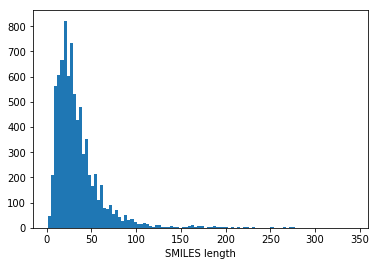

In [6]:
#Get StrLen
slen = df.smiles.str.len()
plt.hist(slen,bins=100)
plt.xlabel("SMILES length")
plt.show()


In [7]:
ToKeep = ["smiles","target1","target2","target9","target10","target11"]

In [8]:
#Keep short for debuging
slen = df.smiles.str.len()
df = df[slen < 75]
df = df[ToKeep]
print(len(df))
slen = df.smiles.str.len()
LongestStr = df.smiles.str.len().max()

7470


In [9]:
df.isnull().sum().sort_values()

smiles         0
target1      521
target9      681
target2     1000
target10    1148
target11    1926
dtype: int64

In [10]:
df.head()

,smiles,target1,target2,target9,target10,target11
2828,Nc1nc(=O)c(Br)c(-c2ccccc2)[nH]1,0.0,NaN,0.0,0.0,0.0
2308,O=CO[AlH3](OC=O)OC=O,0.0,0.0,0.0,0.0,NaN
1935,O=[N+]([O-])c1ccccc1CCl,0.0,0.0,0.0,0.0,0.0
6945,CC(C)c1ncc([N+](=O)[O-])n1C,0.0,0.0,0.0,NaN,0.0
4102,Nc1ccc(F)cc1F,0.0,0.0,0.0,0.0,0.0


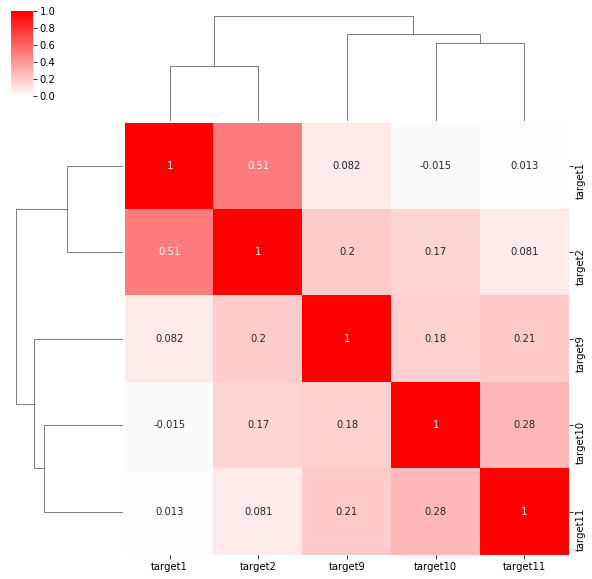

In [11]:
#Correlation between toxicity
sns.clustermap(df.corr(),cmap="bwr",center=0.0,annot=True)
plt.show()

In [12]:
#String based model

#Get all character
cstr = [] # All caracters array
for l in list(df.smiles):cstr += list(l)
    
#Get all unique carac
Vocab = sorted(np.unique(cstr))
VocabSize = len(Vocab)
VocabToId = dict()
for i in range(len(Vocab)):
    VocabToId[Vocab[i]] = i




In [13]:
#Encode SMILES
print("LongestStr=%d" % (LongestStr))
X_One_hot = np.zeros((len(df),LongestStr,VocabSize))
for j,(n) in enumerate(df.smiles):
    for i,(car) in enumerate(list(n)):
        X_One_hot[j,i,VocabToId[car]] = 1.0

#Encode class
Y_hat = df.filter(regex="target").fillna(-1).as_matrix()
ClassSize = len(Y_hat[0])

#Build Mask for loss function
Mask = (df.filter(regex="target").isnull()==False).as_matrix()*1



LongestStr=74


In [14]:
def TrainStringModel(X_One_hot,Y_hat,Mask,slen,Epoch=10,num_hidden = 50,OtherTox = [],ToxHidden=50):
    #Reset Graph
    tf.reset_default_graph()
    
    #Get Shape
    LongestStr = X_One_hot.shape[1]
    VocabSize = X_One_hot.shape[2]
    ClassSize = len(Y_hat[0])
    
    #Create X, which would be the encoded caracter
    X = tf.placeholder(tf.float32, shape=[None, LongestStr, VocabSize],name="X")
    #Create Y, which is the encoded class
    Y = tf.placeholder(tf.float32,shape=[None,ClassSize],name="Y")
    #Mask for loss function
    M = tf.placeholder(tf.float32,shape=[None,ClassSize],name="Mask")
    #SeqLen for RNN
    SeqLen = tf.placeholder(tf.int64,shape = [None],name="SeqLen")

    if len(OtherTox) != 0:
        Tox = tf.placeholder(tf.float32, shape=[None, OtherTox.shape[1]],name="Tox")


    #Build graph
    # Define a lstm cell with tensorflow
    fw_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden)
    bw_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden)

    #Bidirectionnal_RNN
    output,(fstates,bstates) = tf.nn.bidirectional_dynamic_rnn(fw_cell,bw_cell,X
                                                             ,sequence_length=SeqLen,dtype=tf.float32)
    #Concat the 2 hidden state
    ConcatStat = tf.concat([fstates[-1],bstates[-1]],1)
    
    if len(OtherTox) != 0:
        ToxDense = tf.layers.dense(Tox,ToxHidden,name="ToxDense1")
        ToxDense = tf.layers.dense(ToxDense,ToxHidden,name="ToxDense2",activation="relu")
        ConcatStat = tf.concat([ConcatStat,ToxDense],1)
        
    #Run Hidden state true one layer of sigmoid
    Prediction = tf.layers.dense(ConcatStat,ClassSize,name="Prediction",activation="sigmoid")

    #Define Loss
    loss = tf.reduce_sum(tf.pow(Prediction-Y, 2)*M)
    #Define optimiser
    train_op = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(loss)

    #Init graph
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    #Train size
    Batch_Size = 256
    #print(len(df))
    NbsOfBatch = len(df)/Batch_Size
    TrainingBatch = int(NbsOfBatch*4/5)
    TS = TrainingBatch*Batch_Size
    #print(NbsOfBatch,TrainingBatch,TS)


    #Keep all loss
    TrainLoss = []
    TestLoss = []


    TestAUCs = []
    TrainAUCs = []
    for i in range(Epoch):
        totloss = 0.0
        for k in range(TrainingBatch):
            loss_val = 0
            feed_dict = {X: X_One_hot[k*Batch_Size:(k+1)*Batch_Size],
                                Y: Y_hat[k*Batch_Size:(k+1)*Batch_Size],
                                SeqLen:slen[k*Batch_Size:(k+1)*Batch_Size],
                                M: Mask[k*Batch_Size:(k+1)*Batch_Size]
                               }
            if len(OtherTox) != 0:
                feed_dict[Tox] = OtherTox[k*Batch_Size:(k+1)*Batch_Size]
            #Get loss and gradient
            _, loss_val = sess.run([train_op, loss], feed_dict=feed_dict)
            totloss += loss_val
            #print(loss_val,k,k*Batch_Size,(k+1)*Batch_Size)
        
        #Run on Test
        feed_dict = {X: X_One_hot[TS:],
                        Y: Y_hat[TS:],
                        SeqLen:slen[TS:],
                        M: Mask[TS:]
                       }
        if len(OtherTox) != 0:
            feed_dict[Tox] = OtherTox[TS:]
        
        
        [loss_val,pred_test] = sess.run([loss,Prediction], feed_dict=feed_dict)
                               
        #Append loss for train and test
        TrainLoss.append(totloss/float(TS))
        TestLoss.append(loss_val/float(len(X_One_hot[TS:])))
        
        #Get AUC
        auc = get_auc(pred_test,Y_hat[TS:])
        TestAUCs.append(auc)
        
        #Get AUC on train
        #Run on Test
        feed_dict = {X: X_One_hot[:TS],
                        Y: Y_hat[:TS],
                        SeqLen:slen[:TS],
                        M: Mask[:TS]
                       }
        if len(OtherTox) != 0:
            feed_dict[Tox] = OtherTox[:TS]
        
        [loss_val,pred] = sess.run([loss,Prediction], feed_dict=feed_dict)
        auc = get_auc(pred,Y_hat[:TS])
        TrainAUCs.append(auc)
        if (i % 25 == 0) or (i == Epoch-1):
            print("EPOCH:%3d TrL:%.2f TeL:%.2f TrAUC:%.2f TeAUC:%.2f" % (i,totloss/float(TS),TestLoss[-1],TrainAUCs[-1][-1],TestAUCs[-1][-1]))
    return([TrainLoss,TestLoss,TrainAUCs,TestAUCs,pred_test,Y_hat[TS:]])


In [15]:
len(Y_hat[0])

5

In [16]:
Epoch = 50

AUCs = dict()

AllPredTestS = []
AllPredTestO = []

AllLabelTestS = []
AllLabelTestO = []

for t in range(len(Y_hat[0])):
    print("T=%d" % (t))
    AUCs["Target"+str(t)] = dict()
    #No other tox info
    [TrainLoss,TestLoss,TrainAUCs,TestAUCs,pred_test_s,lab_test_s] = TrainStringModel(
        X_One_hot,Y_hat[:,[t]],Mask[:,[t]],slen,Epoch=Epoch)
    AUCs["Target"+str(t)]["SingleModel"] = TestAUCs[-1][0]
    
    AllPredTestS.append(pred_test_s)
    AllLabelTestS.append(lab_test_s)
    
    #Other tox info
    OTox = build_OtherTox(Y_hat,ToIgnore=[t])
    OTox = np.array(OTox)
    [TrainLoss,TestLoss,TrainAUCs,TestAUCs,pred_test_o,lab_test_o] = TrainStringModel(
        X_One_hot,Y_hat[:,[t]],Mask[:,[t]],slen,OtherTox=OTox,Epoch=Epoch)
    
    AUCs["Target"+str(t)]["ExtraInfo"] = TestAUCs[-1][0]
    
    AllPredTestO.append(pred_test_o)
    AllLabelTestO.append(lab_test_o)




T=0
Instructions for updating:
seq_dim is deprecated, use seq_axis instead
Instructions for updating:
batch_dim is deprecated, use batch_axis instead
EPOCH:  0 TrL:0.17 TeL:0.10 TrAUC:0.44 TeAUC:0.43
EPOCH: 25 TrL:0.03 TeL:0.03 TrAUC:0.67 TeAUC:0.70
EPOCH: 49 TrL:0.02 TeL:0.02 TrAUC:0.77 TeAUC:0.71
EPOCH:  0 TrL:0.12 TeL:0.05 TrAUC:0.62 TeAUC:0.59
EPOCH: 25 TrL:0.02 TeL:0.02 TrAUC:0.77 TeAUC:0.76
EPOCH: 49 TrL:0.02 TeL:0.02 TrAUC:0.80 TeAUC:0.83
T=1
EPOCH:  0 TrL:0.17 TeL:0.11 TrAUC:0.46 TeAUC:0.44
EPOCH: 25 TrL:0.02 TeL:0.03 TrAUC:0.38 TeAUC:0.43
EPOCH: 49 TrL:0.02 TeL:0.03 TrAUC:0.52 TeAUC:0.57
EPOCH:  0 TrL:0.13 TeL:0.05 TrAUC:0.74 TeAUC:0.72
EPOCH: 25 TrL:0.01 TeL:0.01 TrAUC:0.95 TeAUC:0.94
EPOCH: 49 TrL:0.01 TeL:0.01 TrAUC:0.94 TeAUC:0.93
T=2
EPOCH:  0 TrL:0.18 TeL:0.12 TrAUC:0.56 TeAUC:0.57
EPOCH: 25 TrL:0.03 TeL:0.03 TrAUC:0.75 TeAUC:0.71
EPOCH: 49 TrL:0.03 TeL:0.03 TrAUC:0.76 TeAUC:0.71
EPOCH:  0 TrL:0.09 TeL:0.05 TrAUC:0.80 TeAUC:0.82
EPOCH: 25 TrL:0.02 TeL:0.03 TrAUC:0.87 TeA

In [17]:
AUCs["All"] = dict()
for (p,l,name) in zip([AllPredTestS,AllPredTestO],[AllLabelTestS,AllLabelTestO],["SingleModel","ExtraInfo"]):

    TempPred = np.array(p)[:,:,0]
    TempLabel = np.array(l)[:,:,0]

    TempPred = TempPred.reshape(TempPred.shape[1],TempPred.shape[0])
    TempLabel = TempLabel.reshape(TempLabel.shape[1],TempLabel.shape[0])

    print(TempPred.shape,TempLabel.shape)
    
    taucs = get_auc(TempPred,TempLabel)
    print(taucs)
    for t in range(len(taucs)):
        if t+1 == len(taucs):
            if "All" not in AUCs:AUCs["All"] = dict()
            AUCs["All"][name] = taucs[t]
        else:
            print(t,name,taucs[t])
         #   if "Target"+str(t) not in AUCs: AUCs["Target"+str(t)] = dict()
            #AUCs["Target"+str(t)][name] = taucs[t]

(1582, 5) (1582, 5)
[0.78005341023323826, 0.81511163714417545, 0.85333915320820597, 0.75595657276995309, 0.71478842262690245, 0.78349310045640852]
0 SingleModel 0.780053410233
1 SingleModel 0.815111637144
2 SingleModel 0.853339153208
3 SingleModel 0.75595657277
4 SingleModel 0.714788422627
(1582, 5) (1582, 5)
[0.8966725221611852, 0.88476198118317317, 0.91435690382656765, 0.88668818466353683, 0.87060790006158173, 0.8908000235033946]
0 ExtraInfo 0.896672522161
1 ExtraInfo 0.884761981183
2 ExtraInfo 0.914356903827
3 ExtraInfo 0.886688184664
4 ExtraInfo 0.870607900062


In [18]:
pd.DataFrame(AUCs)

,All,Target0,Target1,Target2,Target3,Target4
ExtraInfo,0.890800,0.826749,0.926919,0.842100,0.838434,0.895308
SingleModel,0.783493,0.714812,0.568804,0.708013,0.762756,0.860438


In [19]:
[TrainLoss,TestLoss,TrainAUCs,TestAUCs,_,_] = TrainStringModel(X_One_hot,Y_hat,Mask,slen,Epoch=Epoch)

EPOCH:  0 TrL:0.88 TeL:0.60 TrAUC:0.56 TeAUC:0.56
EPOCH: 25 TrL:0.20 TeL:0.22 TrAUC:0.78 TeAUC:0.76
EPOCH: 49 TrL:0.19 TeL:0.21 TrAUC:0.81 TeAUC:0.79


In [20]:
TestAUCs[-1]

[0.59544093944278154,
 0.76139624423377283,
 0.65245184724943839,
 0.69165331712975753,
 0.81369560588571499,
 0.78557006033809773]

In [21]:
for t in range(len(TestAUCs[-1])):
    print(t)
    if t+1 == len(TestAUCs[0]):
        if "All" not in AUCs:AUCs["All"] = dict()
        AUCs["All"]["TrainAll"] = TestAUCs[-1][t]
    else:
        if "Target"+str(t) not in AUCs: AUCs["Target"+str(t)] = dict()
        AUCs["Target"+str(t)]["TrainAll"] = TestAUCs[-1][t]

0
1
2
3
4
5


In [22]:
pd.DataFrame(AUCs).transpose()

,ExtraInfo,SingleModel,TrainAll
All,0.890800,0.783493,0.785570
Target0,0.826749,0.714812,0.595441
Target1,0.926919,0.568804,0.761396
Target2,0.842100,0.708013,0.652452
Target3,0.838434,0.762756,0.691653
Target4,0.895308,0.860438,0.813696


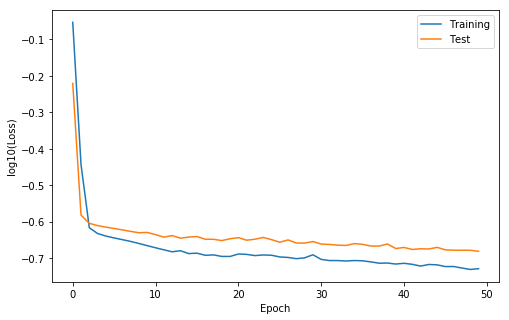

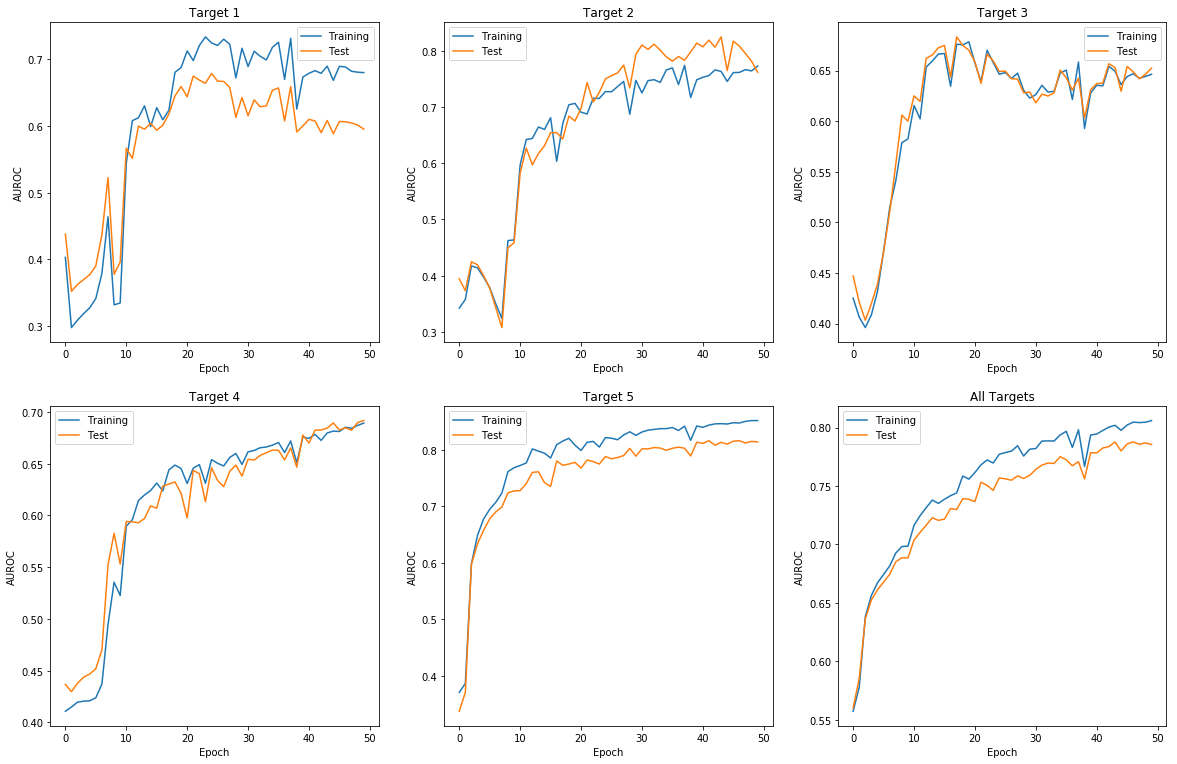

In [23]:
figsize(8,5)
plt.plot(range(len(TrainLoss)),np.log10(TrainLoss),label="Training")
plt.plot(range(len(TestLoss)),np.log10(TestLoss),label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("log10(Loss)")
plt.show()
figsize(20,20)
for t in range(len(TestAUCs[0])):
    plt.subplot(3, 3, t+1)
    plt.plot(range(len(TrainLoss)),np.array(TrainAUCs)[:,t],label="Training")
    plt.plot(range(len(TestLoss)),np.array(TestAUCs)[:,t],label="Test")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("AUROC")
    if t+1 == len(TestAUCs[0]):
        plt.title("All Targets")
    else:
        plt.title("Target %d" % (t+1))
    #plt.show()
    #print(t,)